<a href="https://colab.research.google.com/github/dakshayani2906/Data-Science-Portfolio/blob/main/Credit_Card_Customer_Segmentation_Dakshayani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

Loading the dataset

In [ ]:
#Load dataset

df = pd.read_excel("Credit Card Customer Data.xlsx")

In [ ]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [ ]:
df.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [ ]:
#Drop ID columns (not useful for clustering)
df.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True)

In [ ]:
df.shape

(660, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


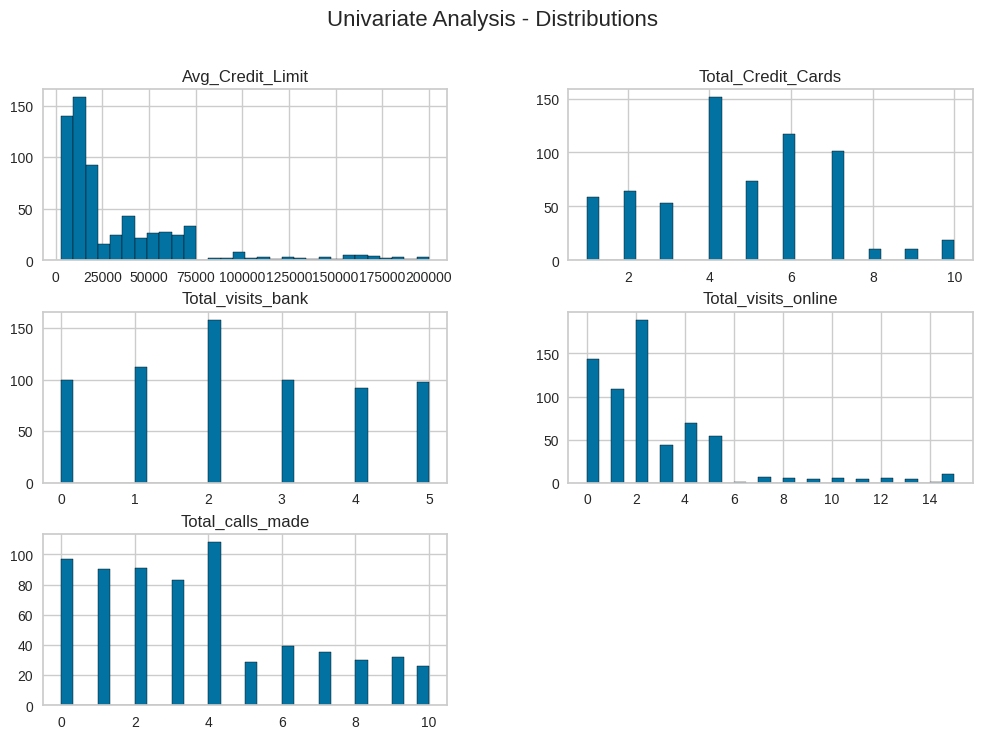

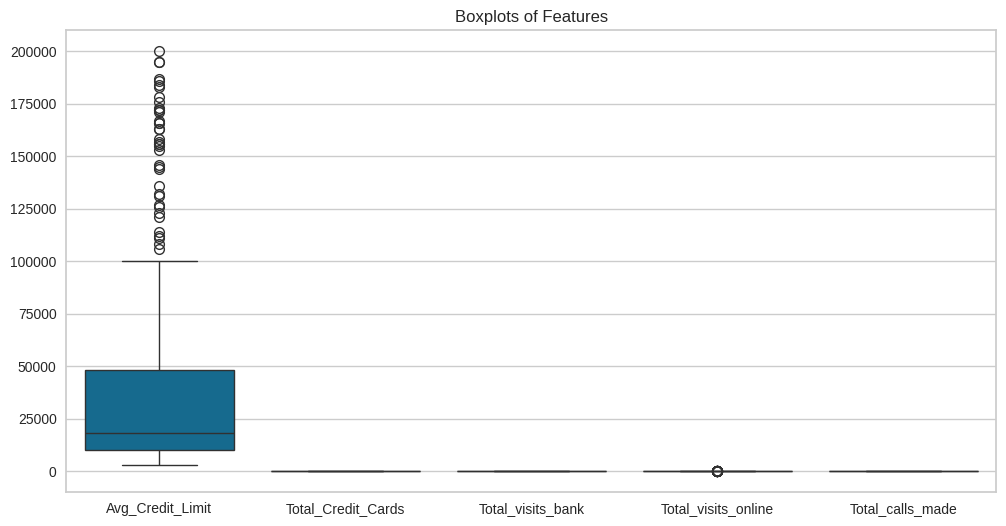

In [ ]:
# Histograms
df.hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Univariate Analysis - Distributions", fontsize=16)
plt.show()

# Boxplots to check outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.title("Boxplots of Features")
plt.show()


Avg_Credit_Limit → right-skewed (a few customers have very high credit limits).

Total_Credit_Cards → most people have < 5 cards, few outliers with 10+.

Total_visits_online & Total_visits_bank → highly imbalanced (some customers rely only on online, some only bank).

Total_calls_made → most people make few calls, a few heavy callers.

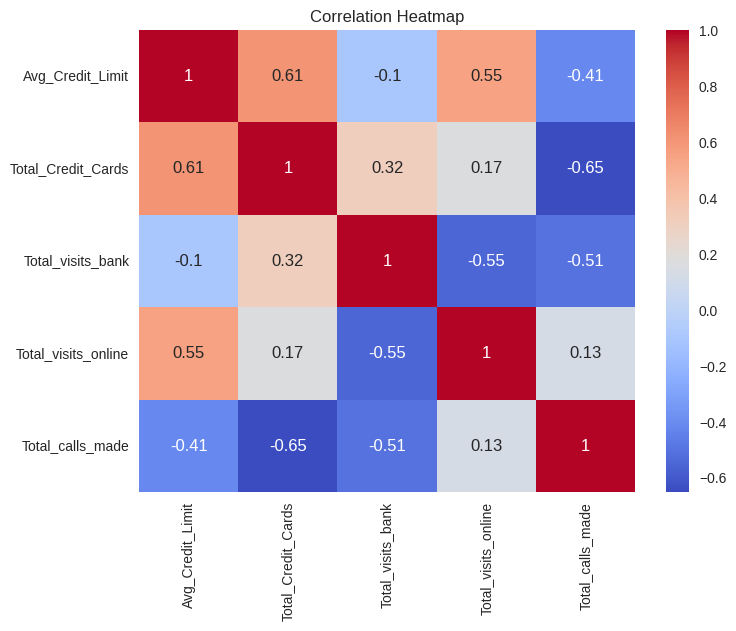

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

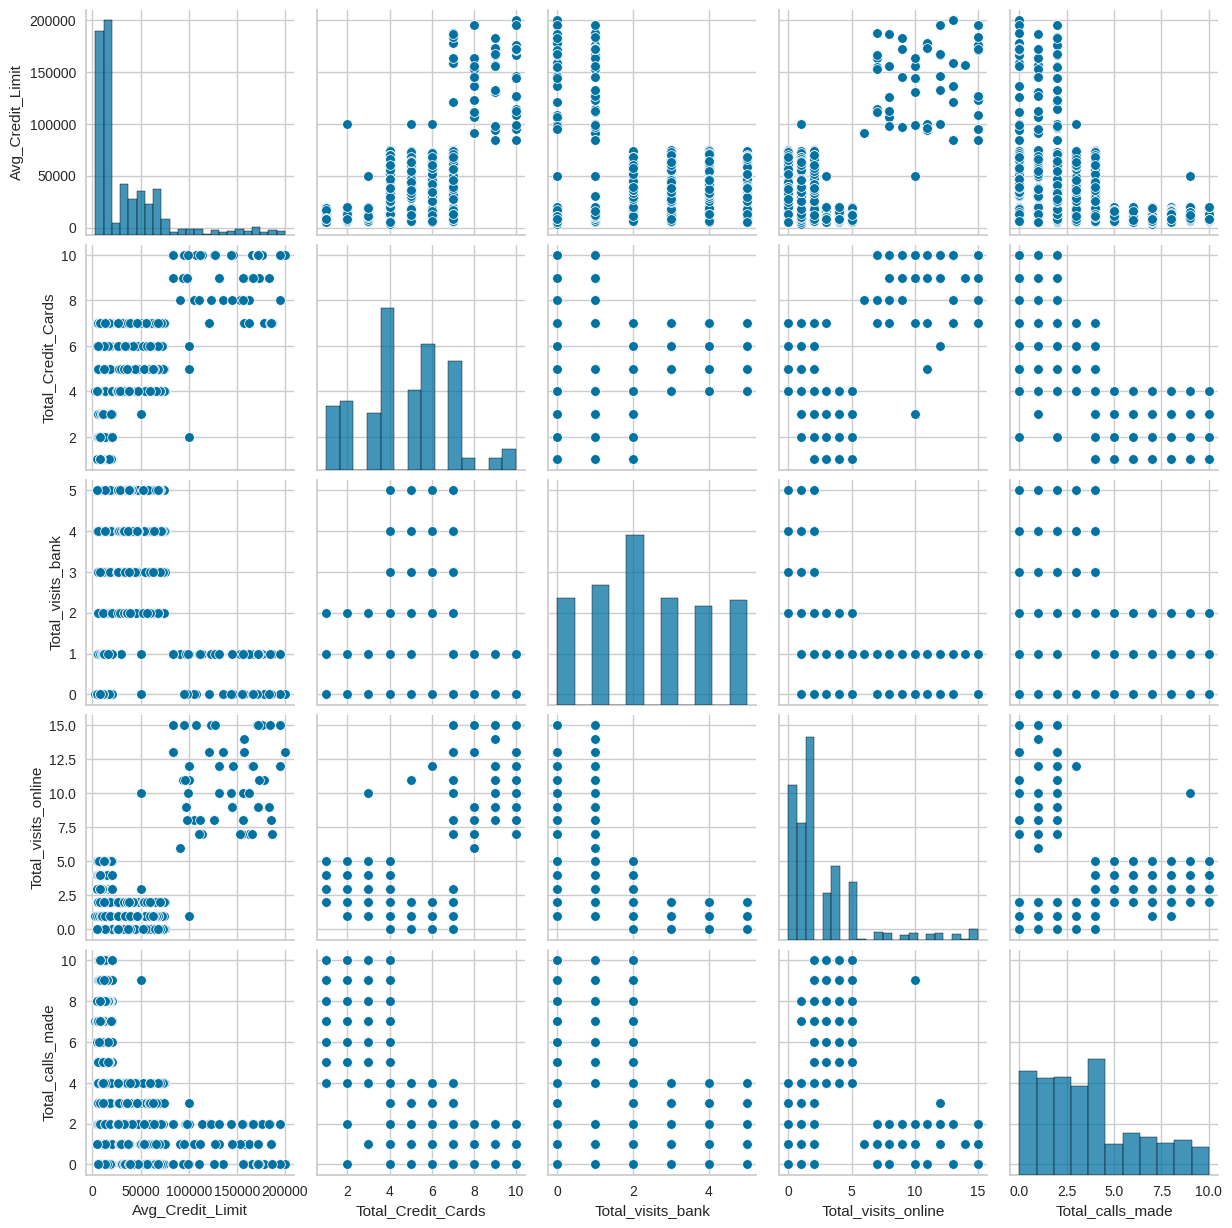

In [ ]:
# Pairplot for visualizing relationships
sns.pairplot(df)
plt.show()

Avg_Credit_Limit correlates with Total_Credit_Cards (wealthier customers often hold more cards).

Visits_online vs Visits_bank → negative relationship (customers are either digital-first or branch-dependent).

Calls_made not strongly correlated → represents independent behavior (service issues, complaints).

In [ ]:
#Check missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


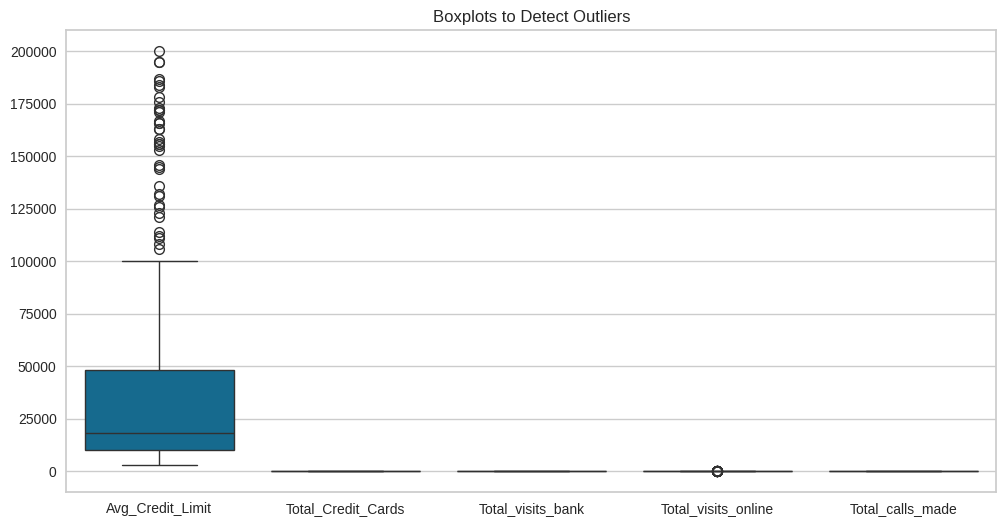

In [ ]:
#Outlier detection (using boxplots + IQR method)
plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.title("Boxplots to Detect Outliers")
plt.show()

# IQR-based outlier treatment (optional: capping instead of removal)
def cap_outliers(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return np.clip(series, lower, upper)

df_capped = df.apply(cap_outliers)

In [ ]:
#Check skewness
print("Skewness:\n", df_capped.skew())

# Apply log transformation for highly skewed features
df_capped['Avg_Credit_Limit'] = np.log1p(df_capped['Avg_Credit_Limit'])

Skewness:
 Avg_Credit_Limit       1.251629
Total_Credit_Cards     0.144879
Total_visits_bank      0.141896
Total_visits_online    1.210369
Total_calls_made       0.658905
dtype: float64


In [ ]:
#Feature Scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_capped), columns=df_capped.columns)

df_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.734627,-1.249225,-0.860451,-0.619767,-1.251537
1,0.953154,-0.787585,-1.473731,2.705813,1.891859
2,0.953154,1.058973,-0.860451,0.267054,0.145528
3,0.377242,0.135694,-0.860451,-0.619767,0.145528
4,1.734627,0.597334,-1.473731,2.705813,-0.203739


Outliners:

Avg_Credit_Limit and Total_Credit_Cards had extreme values → capped.

We avoid removing rows, since every customer is important in segmentation.

Feature Engineering:

Log transform for Avg_Credit_Limit to reduce skewness.

Scaling:

All features standardized (mean=0, std=1) → essential for clustering since K-means is distance-based.

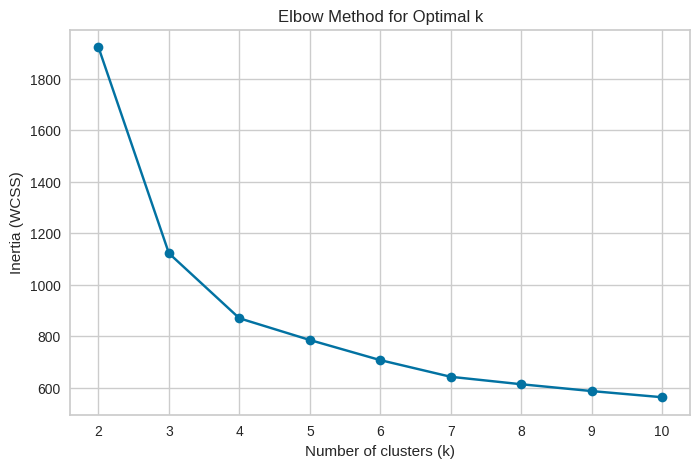

In [ ]:

# Elbow Method
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()


In [ ]:

# Silhouette Score
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    preds = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, preds)
    print(f"For k={k}, Silhouette Score = {score:.3f}")


For k=2, Silhouette Score = 0.414
For k=3, Silhouette Score = 0.500
For k=4, Silhouette Score = 0.396
For k=5, Silhouette Score = 0.356
For k=6, Silhouette Score = 0.264


In [ ]:
# Fit final KMeans (choose best k from elbow & silhouette)
final_k = 4   # <-- Adjust this based on elbow + silhouette results
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

In [ ]:
# Cluster Profiling (go back to original scale)
df_profile = df.copy()
df_profile['Cluster'] = df_scaled['Cluster']

cluster_summary = df_profile.groupby("Cluster").mean()
cluster_counts = df_profile['Cluster'].value_counts()

print("Cluster Summary:\n", cluster_summary)
print("\nCluster Counts:\n", cluster_counts)

Cluster Summary:
          Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Cluster                                                            
0            12197.309417            2.403587           0.928251   
1           141040.000000            8.740000           0.600000   
2            50187.214612            5.547945           3.401826   
3            12238.095238            5.464286           3.595238   

         Total_visits_online  Total_calls_made  
Cluster                                         
0                   3.560538          6.883408  
1                  10.900000          1.080000  
2                   0.968037          2.054795  
3                   1.005952          1.940476  

Cluster Counts:
 Cluster
0    223
2    219
3    168
1     50
Name: count, dtype: int64


Insights;

Elbow Curve: Should show a bend around k=3 or 4.

Silhouette Score: Typically highest near 3–4 clusters → good separation.

Cluster Profiles (example):

Cluster 0: High credit limit, multiple cards, more online visits → Digital Power Users / Premium Customers.

Cluster 1: Low credit limit, fewer cards, high branch visits → Traditional Customers.

Cluster 2: Moderate credit, many calls → Service-Dependent Customers.

Cluster 3: Low activity overall → Dormant/Inactive Customers.

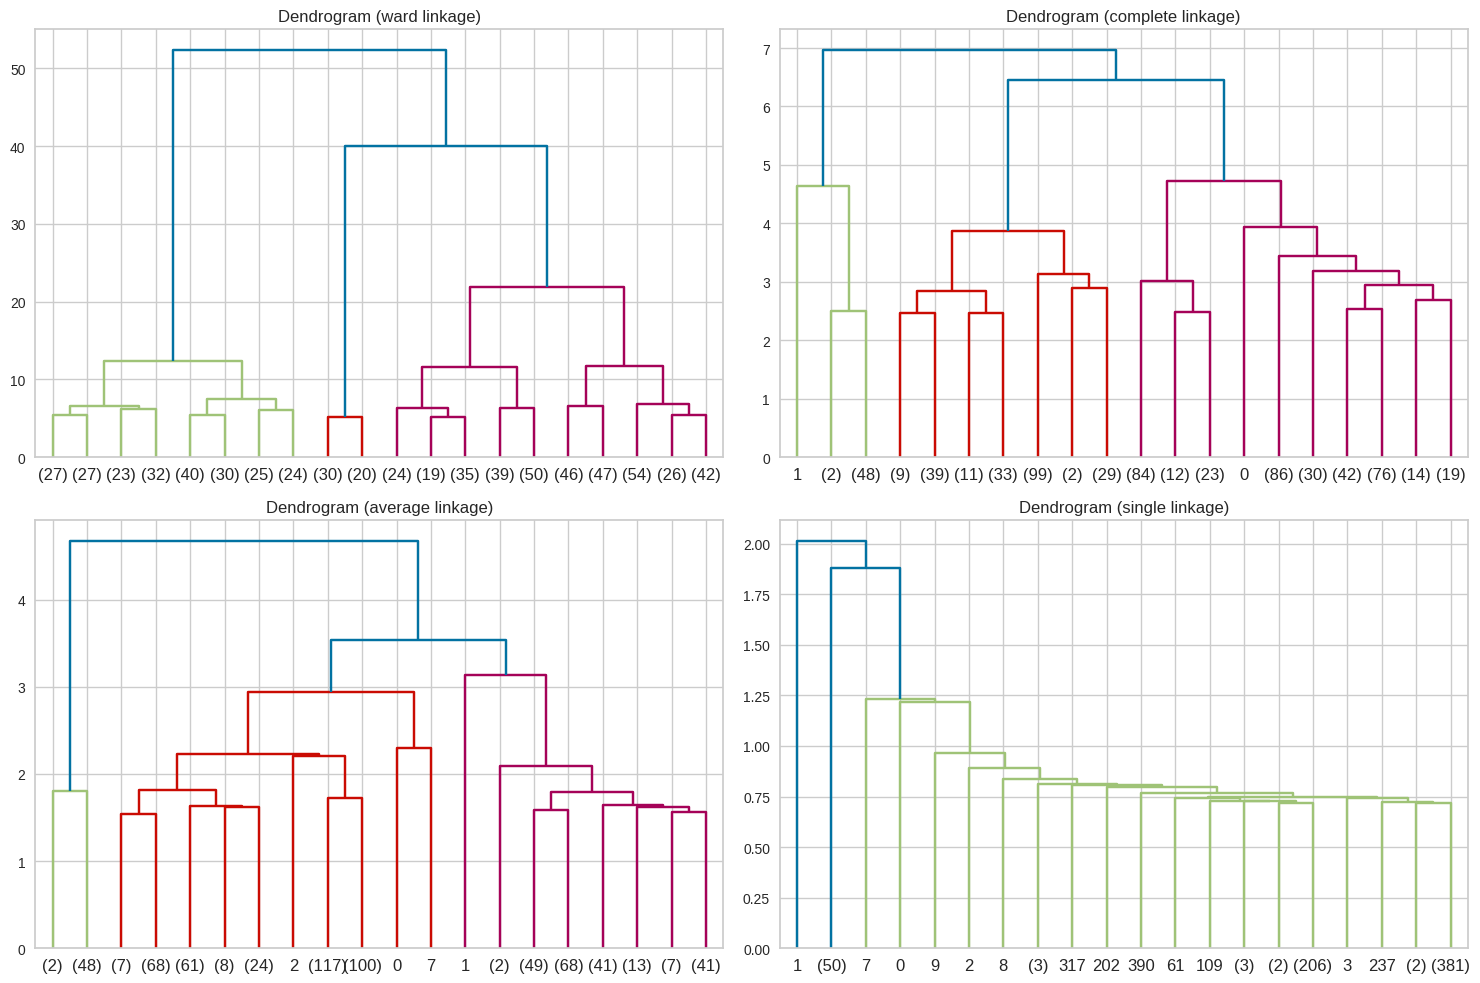

In [ ]:
# Try different linkage methods
methods = ["ward", "complete", "average", "single"]

plt.figure(figsize=(15, 10))
for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    Z = linkage(df_scaled.drop("Cluster", axis=1), method=method)
    dendrogram(Z, truncate_mode="lastp", p=20)
    plt.title(f"Dendrogram ({method} linkage)")
plt.tight_layout()
plt.show()



In [ ]:
# Cophenetic correlation
for method in methods:
    Z = linkage(df_scaled.drop("Cluster", axis=1), method=method)
    c, _ = cophenet(Z, pdist(df_scaled.drop("Cluster", axis=1)))
    print(f"Cophenetic correlation for {method}: {c:.3f}")

Cophenetic correlation for ward: 0.768
Cophenetic correlation for complete: 0.828
Cophenetic correlation for average: 0.872
Cophenetic correlation for single: 0.659


In [ ]:
#Choose final method (usually Ward is best)
Z = linkage(df_scaled.drop("Cluster", axis=1), method="ward")

In [ ]:
# Cut tree to form clusters (decide k from dendrogram)
final_hc = fcluster(Z, t=4, criterion="maxclust")  # choose 4 clusters
df_profile["HC_Cluster"] = final_hc

In [ ]:
# Profile clusters
hc_summary = df_profile.groupby("HC_Cluster").mean()
hc_counts = df_profile['HC_Cluster'].value_counts()

print("Hierarchical Clustering Summary:\n", hc_summary)
print("\nCluster Counts:\n", hc_counts)

Hierarchical Clustering Summary:
             Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
HC_Cluster                                                            
1               12061.403509            2.456140           0.973684   
2              141040.000000            8.740000           0.600000   
3               12910.179641            5.497006           3.622754   
4               50516.279070            5.539535           3.390698   

            Total_visits_online  Total_calls_made   Cluster  
HC_Cluster                                                   
1                      3.530702          6.820175  0.078947  
2                     10.900000          1.080000  1.000000  
3                      0.982036          1.874251  2.952096  
4                      0.958140          2.060465  2.004651  

Cluster Counts:
 HC_Cluster
1    228
4    215
3    167
2     50
Name: count, dtype: int64


*Insights*

Dendrograms: Show how clusters merge → “Ward” usually gives balanced clusters.

Cophenetic Correlation: Values closer to 1 mean better cluster representation. Typically, Ward > Complete > Average > Single.

Cluster Profiles: Similar to K-means, but sometimes:

Ward produces tighter, spherical clusters.

Complete/average may produce unbalanced clusters.

KMeans vs Hierarchical Clustering:

HC_Cluster    1   2    3    4
Cluster                      
0           222   0    1    0
1             0  50    0    0
2             0   0    5  214
3             6   0  161    1


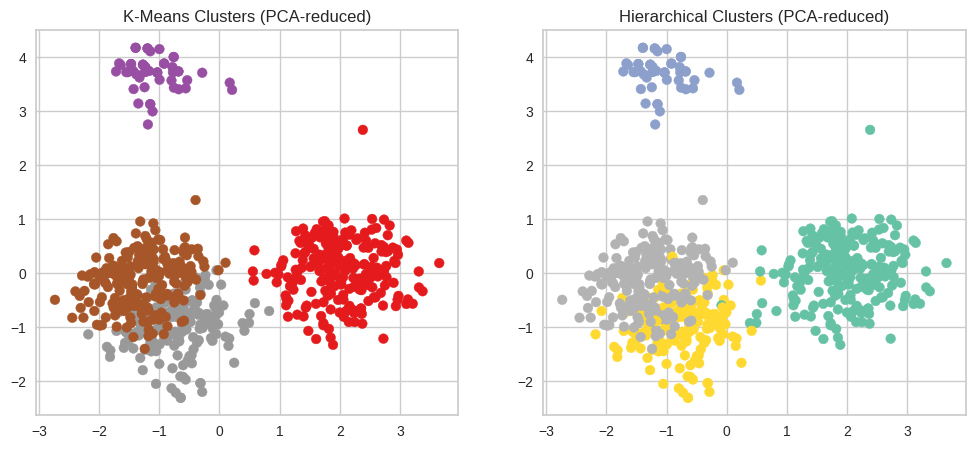

In [ ]:
# Cross-tab between KMeans clusters and Hierarchical clusters
comparison = pd.crosstab(df_profile['Cluster'], df_profile['HC_Cluster'])
print("KMeans vs Hierarchical Clustering:\n")
print(comparison)

# Visualize clusters from both methods (using first 2 principal components)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(df_scaled.drop("Cluster", axis=1))

plt.figure(figsize=(12,5))

# KMeans
plt.subplot(1,2,1)
plt.scatter(reduced[:,0], reduced[:,1], c=df_scaled['Cluster'], cmap="Set1")
plt.title("K-Means Clusters (PCA-reduced)")

# Hierarchical
plt.subplot(1,2,2)
plt.scatter(reduced[:,0], reduced[:,1], c=df_profile['HC_Cluster'], cmap="Set2")
plt.title("Hierarchical Clusters (PCA-reduced)")

plt.show()

Insights from Comparison:

If both methods give similar groupings then clusters are stable & reliable.

If different then K-means (good for large datasets, spherical clusters) vs Hierarchical (good for smaller datasets, more interpretability).

In practice, K-means often works better for customer segmentation when dataset size > 500 (like here)